In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import tensorflow as tf
import utils.data
from utils.layers import Encoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mfcc')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [6]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train.shape[-2], X_train.shape[-1]),return_sequences=True))
lstm_model.add(LSTM(50, input_shape=(X_train.shape[-2], X_train.shape[-1]),return_sequences=True))
lstm_model.add(LSTM(50, input_shape=(X_train.shape[-2], X_train.shape[-1])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(len(data["mapping"]), activation='softmax'))

In [7]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 50)           12800     
                                                                 
 lstm_1 (LSTM)               (None, 130, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 53,710
Trainable params: 53,710
Non-trainable params: 0
_________________________________________________________________


In [8]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

In [9]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [10]:
lstm_history = lstm_model.fit(X_train, Y_train,
              batch_size=32,
              epochs=40,
              validation_data=(X_valid, Y_valid),
              verbose=1, 
              callbacks=es)

Epoch 1/40
219/219 [==============================] - 10s 24ms/step - loss: 1.6533 - accuracy: 0.4202 - val_loss: 1.9407 - val_accuracy: 0.3385
Epoch 2/40
219/219 [==============================] - 5s 21ms/step - loss: 1.2947 - accuracy: 0.5650 - val_loss: 2.0562 - val_accuracy: 0.3034
Epoch 3/40
219/219 [==============================] - 5s 21ms/step - loss: 1.1886 - accuracy: 0.5974 - val_loss: 1.8224 - val_accuracy: 0.3485
Epoch 4/40
219/219 [==============================] - 5s 22ms/step - loss: 1.0961 - accuracy: 0.6293 - val_loss: 2.0268 - val_accuracy: 0.3516
Epoch 5/40
219/219 [==============================] - 5s 21ms/step - loss: 1.0409 - accuracy: 0.6492 - val_loss: 2.0289 - val_accuracy: 0.3170
Epoch 6/40
219/219 [==============================] - 5s 21ms/step - loss: 0.9877 - accuracy: 0.6668 - val_loss: 2.0336 - val_accuracy: 0.3751
Epoch 7/40
219/219 [==============================] - 5s 21ms/step - loss: 0.9271 - accuracy: 0.6858 - val_loss: 2.0524 - val_accuracy: 0.360

32/32 [==============================] - 1s 32ms/step
              precision    recall  f1-score   support

           0       0.31      0.16      0.21       100
           1       0.80      0.74      0.77        99
           2       0.14      0.13      0.13        99
           3       0.56      0.58      0.57        99
           4       0.09      0.02      0.03        99
           5       0.42      0.44      0.43        99
           6       0.42      0.46      0.44       100
           7       0.92      0.93      0.93       100
           8       0.25      0.32      0.28       100
           9       0.19      0.36      0.25       100

    accuracy                           0.41       995
   macro avg       0.41      0.41      0.40       995
weighted avg       0.41      0.41      0.40       995



<Axes: >

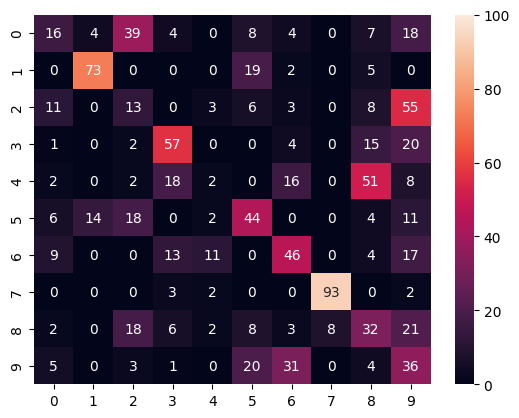

In [12]:
lstm_preds = lstm_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(lstm_preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(lstm_preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)